## Part 2
Under the Swaption tab of IR Data.xlsm, swaption implied volatilities(lognormal) are provided.
### Question 1
Calibrate the displaced-diffusion model to the swaption market data, and document
- a table of σ parameters
- a table of β parameters

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import brentq, least_squares, curve_fit
from scipy.stats import norm
from scipy.integrate import quad
from math import log, exp, sqrt
from scipy import interpolate
from scipy.interpolate import CubicSpline

In [2]:
df_comb=pd.read_csv('df_comb.csv')
#df_comb.head(10)

In [3]:
# read implied vol data create dataframe
df_ForwardSwap = pd.read_csv('df_ForwardSwap.csv')
df_ForwardSwap.set_index(keys = df_ForwardSwap.columns[0], drop = True, inplace=True)
df_vol = pd.read_excel('IR Data.xlsx', 'Swaption', skiprows=[0,1])
df_vol.reset_index(drop=True, inplace = True)
df_vol.iloc[:, 2:] = np.float64(df_vol.iloc[:, 2:]/100)
df_Strikes = df_vol.copy(deep=True)
df_vol['FSR'] = df_ForwardSwap['Swap_Rate']
#df_vol

In [4]:
# create a dataframe for strikes
swaption = pd.read_excel (r'IR Data.xlsx', sheet_name='Swaption', skiprows = 2, header = 0)
swaption = swaption.iloc[0:15,0:13]
swaption.iloc[:, 2:] = swaption.iloc[:, 2:] / 100
df_Strikes = swaption.copy(deep=True)
bps = [0 if i == 7 else float(swaption.columns[i][0:-3]) / 10000
       for i in range(2, len(swaption.columns))]
for i in range(len(swaption.columns[2:])):
    df_Strikes.loc[:, swaption.columns[2 + i]] = df_ForwardSwap.iloc[:, 2] + bps[i] 
#df_Strikes

$V^{payer}_{n,N}(0) = P_{n+1,N}(0)E^{n+1,N}[(S_{n,N}(T)-K)^+]$<br>
$V^{payer}_{n,N}(0) = P_{n+1,N}(0)[S_{n,N}(0)N(d1)-KN(d2)]$

In [5]:
def OISDifInterp(tenor):
    xp = list(df_comb['Tenor'])
    yp = list(df_comb['OIS_DF'])
    return np.interp(tenor, xp, yp)

#PVBP Formula
def PVBP(expiry,tenor):
    m = int(tenor/0.5)
    summa = 0
    for i in range(1,m+1):
        summa += OISDifInterp(expiry + i*0.5)
    return summa*0.5

#Black 76 using PVBP as discount factor
def Black76Lognormal(F,K,T,sigma, opt):
    d1 = (log(F/K)+(sigma*sigma/2)*T[0])/(sigma*sqrt(T[0]))
    d2 = d1-sigma*sqrt(T[0])
    D=PVBP(T[0],T[1]) #Discount Factor is replaced by PVBP
    
    if opt == 'Call':# payer 
        return F*D*norm.cdf(d1) - K*D*norm.cdf(d2)
    elif opt == 'Put': # receiver
        return K*D*norm.cdf(-d2) - F*D*norm.cdf(-d1)
    
def Displaced_Diffusion(F, K, T, sigma, beta, opt):
    return Black76Lognormal(F/beta, K+(1-beta)/beta*F, T,sigma*beta, opt)

def Black76ImpVol(F, K, T, price, opt):
    impliedVol = brentq(lambda x: price - Black76Lognormal(F, K, T, x, opt), 1e-6, 1)  # x is sigma
    return impliedVol


def ImpliedVols(F, K, T,price, opt):
    lst = []
    for i in range(len(price)):
        lst.append(Black76ImpVol(F, K[i], T, price[i], opt))
    return lst


def DisDifImv(F, K1, K2, T,sigma, beta):    
    P, C = [], [] #P is price of Put Option, C is price of Call option
    for k1 in K1: # K1 put strikes
        P.append(Displaced_Diffusion(F, k1, T, sigma, beta, 'Put')) # price is calculated using DD Model
    for k2 in K2: # K2 call strikes
        C.append(Displaced_Diffusion(F, k2, T,sigma, beta, 'Call')) 
    P_imv = ImpliedVols(F, K1, T, P, 'Put')  # implied vol is calculated using Black 76
    C_imv = ImpliedVols(F, K2, T, C, 'Call')
    return P_imv + C_imv

def DisDif_Optmize(F, K1, K2, T, x, MarImpVol):
    P, C = [], []
    for k1 in K1:
        P.append(Displaced_Diffusion(F, k1, T, df_vol.iloc[i,7], x,'Put'))   # price is calculated using DD Model
    for k2 in K2:
        C.append(Displaced_Diffusion(F, k2, T, df_vol.iloc[i,7], x,'Call'))
    P_imv = ImpliedVols(F, K1, T, P, 'Put')    # implied vol is calculated using Black 76
    C_imv = ImpliedVols(F, K2, T, C, 'Call')
    error = np.array(P_imv + C_imv) - np.array(MarImpVol)   # error implied vol vs market vol
    return np.dot(error, error)

In [6]:
ExpTenor = ['1x1','1x2', '1x3','1x5','1x10',
            '5x1','5x2', '5x3','5x5','5x10',
            '10x1','10x2', '10x3','10x5','10x10']
T = [[1,1],[1,2],[1,3],[1,5],[1,10],[5,1],[5,2],[5,3],[5,5],[5,10],[10,1],[10,2],[10,3],[10,5],[10,10]]

In [7]:
# Use Least Square to search for optimal Beta for different forward swap terms
df_DDImpVol = pd.DataFrame()
for i in df_vol.index:
    F = df_vol['FSR'][i]
    K = df_Strikes.loc[i, '-200bps':'+200bps'].values
        
    K1 = np.array(K)[K<F]
    K2 = np.array(K)[K>=F]

    MarketImpVol = df_vol.loc[i, '-200bps':'+200bps'].values

    w = least_squares(lambda x:DisDif_Optmize(F, K1, K2, T[i], x, MarketImpVol),  # (F, K1put, K2call, T, xprice, MarImpVol)  return error
                      0.1,
                      bounds=([1e-6,1]))  
    
    df_vol.loc[i,'β'] = w.x[0]
    df_DDImpVol[ExpTenor[i]+' DisDifImv'] = DisDifImv(F,K1,K2,T[i],
              df_vol.iloc[i,7],df_vol.loc[i,'β'])
    print('Optimal [β]for Displaced-diffusion:', [df_vol.loc[i,'β']])

Optimal [β]for Displaced-diffusion: [1.0000055741797106e-06]
Optimal [β]for Displaced-diffusion: [1.0001652550418121e-06]
Optimal [β]for Displaced-diffusion: [1.000934478889537e-06]
Optimal [β]for Displaced-diffusion: [1.0031653474806452e-06]
Optimal [β]for Displaced-diffusion: [2.2991972060276006e-05]
Optimal [β]for Displaced-diffusion: [1.0011083984153653e-06]
Optimal [β]for Displaced-diffusion: [1.1087849134425545e-06]
Optimal [β]for Displaced-diffusion: [2.0909641970616585e-06]
Optimal [β]for Displaced-diffusion: [1.748711959140975e-05]
Optimal [β]for Displaced-diffusion: [0.05805995136103398]
Optimal [β]for Displaced-diffusion: [1.1886762131301984e-06]
Optimal [β]for Displaced-diffusion: [3.425762833587139e-06]
Optimal [β]for Displaced-diffusion: [1.4714318079104161e-05]
Optimal [β]for Displaced-diffusion: [6.567656404772365e-05]
Optimal [β]for Displaced-diffusion: [0.0051265225200481344]


In [8]:
#tabulate ATM vol for DD model
df_sigma = pd.DataFrame(data    = np.array(df_vol.ATM).reshape(3,5),
                        index   = [1,5,10], 
                        columns = [1,2,3,5,10])
df_sigma

,1,2,3,5,10
1,0.2250,0.2872,0.2978,0.2607,0.2447
5,0.2726,0.2983,0.2998,0.2660,0.2451
10,0.2854,0.2928,0.2940,0.2674,0.2437


In [9]:
#tabulate optimal beta for DD model
df_beta  = pd.DataFrame(data    = np.array(df_vol['β']).reshape(3,5),
                        index   = [1,5,10], 
                        columns = [1,2,3,5,10])
df_beta

,1,2,3,5,10
1,0.000001,0.000001,0.000001,0.000001,0.000023
5,0.000001,0.000001,0.000002,0.000017,0.058060
10,0.000001,0.000003,0.000015,0.000066,0.005127


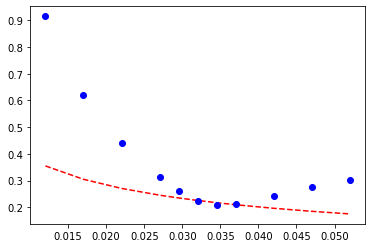

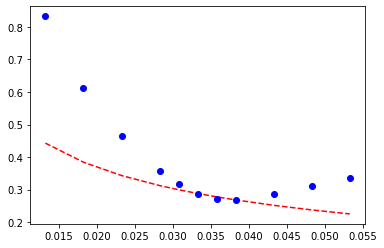

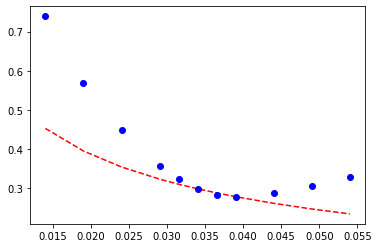

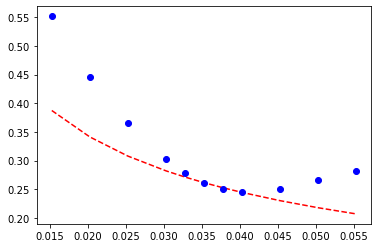

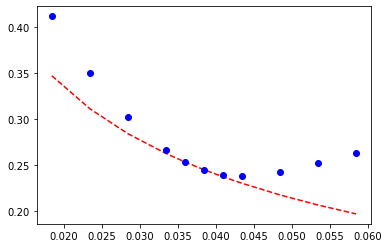

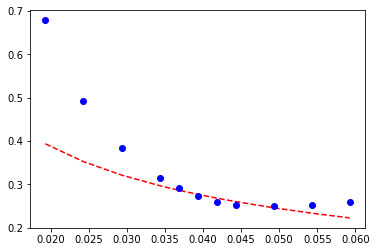

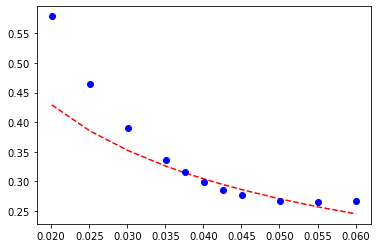

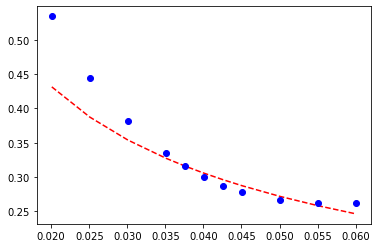

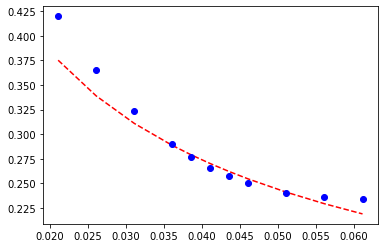

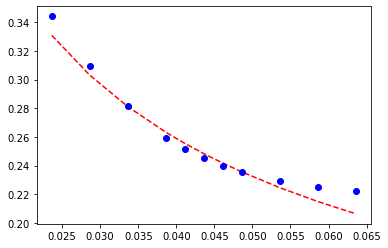

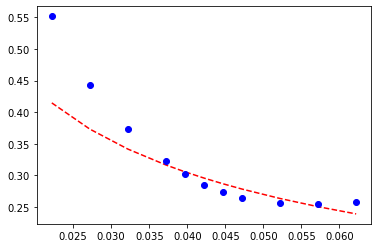

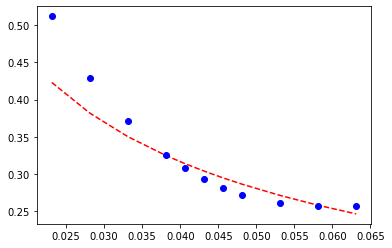

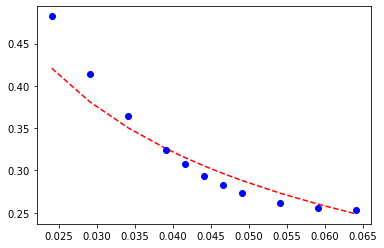

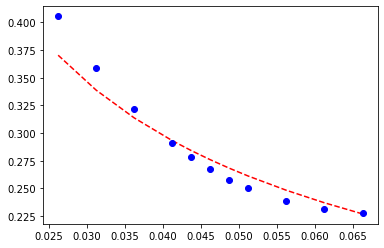

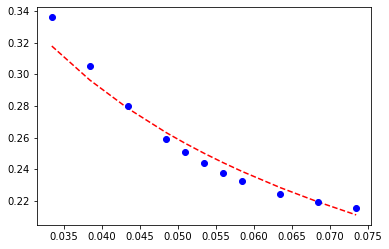

In [10]:
#plot Displaced diffusion model against market vol
for i in df_Strikes.index:
    plt.plot(df_Strikes.iloc[i, 2:],df_DDImpVol[ExpTenor[i]+' DisDifImv'],'r--',
             df_Strikes.iloc[i, 2:],df_vol.loc[i, '-200bps':'+200bps'],'bo')
    plt.show() 

### Question 2
Calibrate the SABR model to the swaption market data using beta = 0.9,and document\
- a table of α parameters
- a table of ρ parameters
- a table of ν parameters

In [11]:
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    if F == K:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T[0])/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T[0])*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom
    return sabrsigma


def sabrcalibration(F, K, T, x, vols, beta):
    err = 0.0
    for i,vol in enumerate(vols):
        sabr_sol = SABR(F, K[i],T,x[0],beta,x[1],x[2])
        err +=(vol - sabr_sol)**2
    return err    

In [12]:
df_SABR = pd.read_excel('IR Data.xlsx', 'Swaption', skiprows=[0,1])
df_SABR.reset_index(drop=True, inplace = True)
df_SABR.iloc[:, 2:] = np.float64(df_SABR.iloc[:, 2:]/100)
df_SABR['FSR'] = df_ForwardSwap['Swap_Rate']
#df_SABR

In [13]:
#SABR calibration 
SABRbeta = 0.9
initial_guess = [0.2, -0.5, 1.5]

for i in df_SABR.index:
    res = least_squares(lambda x: sabrcalibration(df_SABR.loc[i, 'FSR'],
                                                  df_Strikes.iloc[i, 2:],
                                                  T[i],
                                                  x,
                                                  df_SABR.iloc[i, 2:13],
                                                  SABRbeta),
                                                  initial_guess,max_nfev=2000)
#    print(res)
    print(ExpTenor[i],' :',res.x[0],res.x[1],res.x[2] )
    df_SABR.loc[i, 'α'] = res.x[0]
    df_SABR.loc[i, 'ρ'] = res.x[1]
    df_SABR.loc[i, 'ν'] = res.x[2]
    initial_guess = [res.x[0],res.x[1],res.x[2]]

1x1  : 0.13907350912101943 -0.6332261003345103 2.049444184211519
1x2  : 0.1846318406143379 -0.5251243995591848 1.6775467257514658
1x3  : 0.19683782441948822 -0.4828284441065917 1.438248421994124
1x5  : 0.17796783205956732 -0.41403422046001215 1.0657005464940112
1x10  : 0.16992547856390458 -0.25415507259748715 0.7927404661446772
5x1  : 0.16661684962259168 -0.5856595473782966 1.3404191346154646
5x2  : 0.19954860686417714 -0.5471189109757383 1.0621100222526747
5x3  : 0.21034941350155423 -0.5498221840611925 0.9368075259957188
5x5  : 0.19026573738897082 -0.5069629171587126 0.6744995996409221
5x10  : 0.1750766718515683 -0.4202079391244686 0.5110960452197313
10x1  : 0.17824675669222173 -0.54831081312471 1.0101445735115928
10x2  : 0.19631147272768623 -0.5475268199076987 0.9286288401174088
10x3  : 0.20823644528565718 -0.5535462410890943 0.8716427650894274
10x5  : 0.20248543467592886 -0.5663290430889975 0.7237561694227967
10x10  : 0.17941013030206823 -0.5046834073206394 0.5821623494871653


In [14]:
df_SABRImpVol = df_SABR.copy(deep = True)
df_SABRImpVol.to_csv('df_SABRImpVol.csv',sep=',')
#df_SABRImpVol

In [15]:
df_alpha = pd.DataFrame(data    = np.array(df_SABRImpVol['α']).reshape(3,5),
                        index   = [1,5,10], 
                        columns = [1,2,3,5,10])
df_alpha

,1,2,3,5,10
1,0.139074,0.184632,0.196838,0.177968,0.169925
5,0.166617,0.199549,0.210349,0.190266,0.175077
10,0.178247,0.196311,0.208236,0.202485,0.179410


In [16]:
df_rho   = pd.DataFrame(data    = np.array(df_SABRImpVol['ρ']).reshape(3,5),
                        index   = [1,5,10], 
                        columns = [1,2,3,5,10])
df_rho

,1,2,3,5,10
1,-0.633226,-0.525124,-0.482828,-0.414034,-0.254155
5,-0.585660,-0.547119,-0.549822,-0.506963,-0.420208
10,-0.548311,-0.547527,-0.553546,-0.566329,-0.504683


In [17]:
df_nu    = pd.DataFrame(data    = np.array(df_SABRImpVol['ν']).reshape(3,5),
                        index   = [1,5,10], 
                        columns = [1,2,3,5,10])
df_nu

,1,2,3,5,10
1,2.049444,1.677547,1.438248,1.065701,0.792740
5,1.340419,1.062110,0.936808,0.674500,0.511096
10,1.010145,0.928629,0.871643,0.723756,0.582162


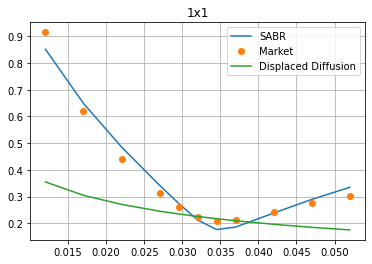

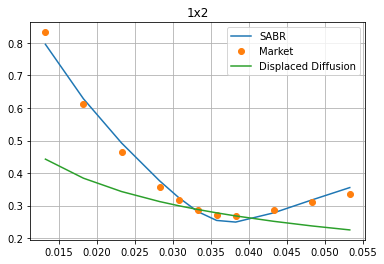

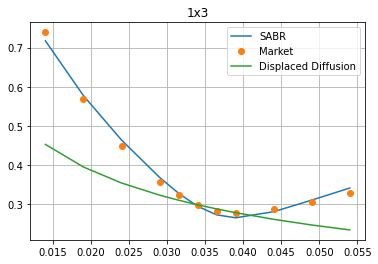

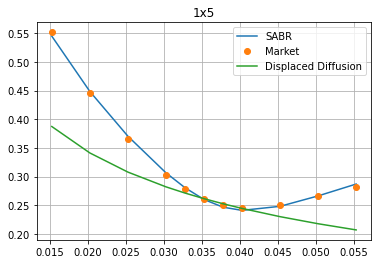

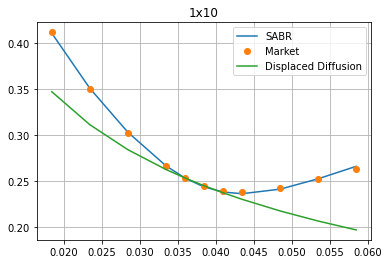

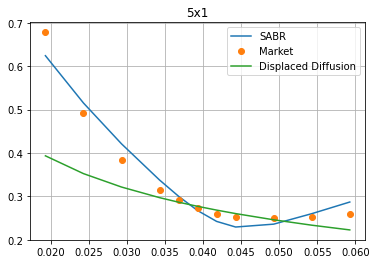

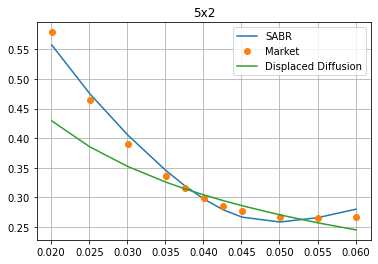

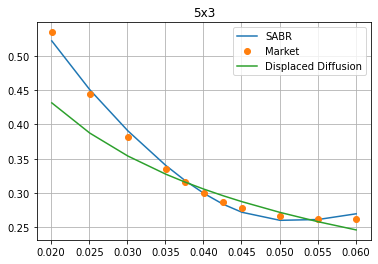

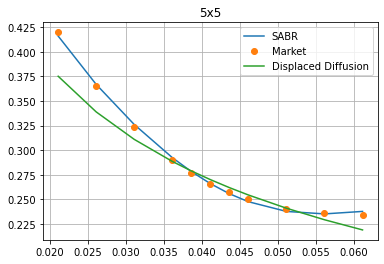

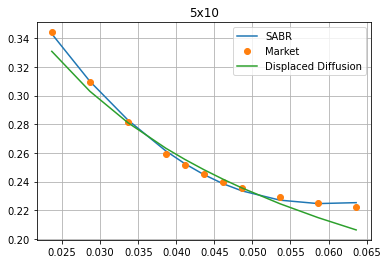

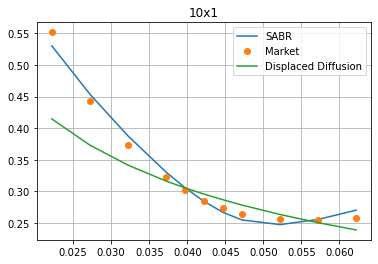

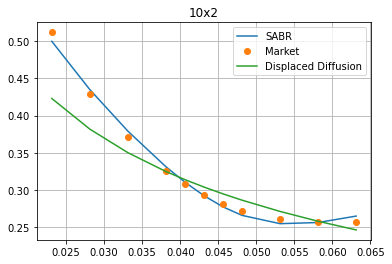

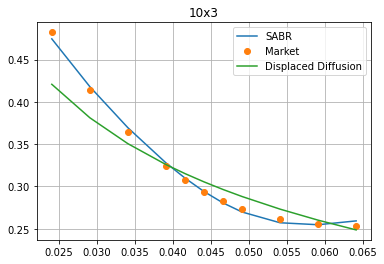

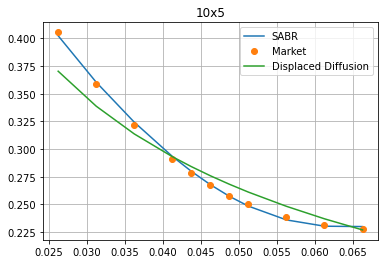

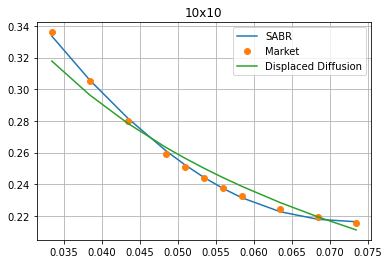

In [18]:
#plot SABR model against market vol
for row in df_SABRImpVol.index:
    for col in df_SABRImpVol.columns[2:13]:
        df_SABRImpVol.loc[row, col] = SABR(
                df_SABRImpVol.loc[row,'FSR'],
                df_Strikes.loc[row, col],
                T[row], 
                df_SABRImpVol.loc[row, 'α'], 
                SABRbeta,
                df_SABRImpVol.loc[row, 'ρ'],
                df_SABRImpVol.loc[row, 'ν'])
    plt.plot(df_Strikes.iloc[row, 2:],df_SABRImpVol.iloc[row, 2:13],label='SABR')
    plt.plot(df_Strikes.iloc[row, 2:],df_SABR.iloc[row, 2:13],'o',label='Market')
    plt.plot(df_Strikes.iloc[row, 2:],df_DDImpVol.iloc[:,row],label="Displaced Diffusion")
    plt.legend()
    plt.grid()
    plt.title(ExpTenor[row])
    plt.show()

In [19]:
#Consoludate SABR implied vol to into df_SABRImpVol dataframe
df_SABRImpVol = df_SABR.copy(deep = True)
for row in df_SABRImpVol.index:
    for col in df_SABRImpVol.columns[2:13]:
        df_SABRImpVol.loc[row, col] = SABR(
                df_SABRImpVol.loc[row,'FSR'],
                df_Strikes.loc[row, col],
                T[row], 
                df_SABRImpVol.loc[row, 'α'], 
                SABRbeta,
                df_SABRImpVol.loc[row, 'ρ'],
                df_SABRImpVol.loc[row, 'ν'])

### Question 3
Price the following swaptions using the calibrated displaced-diffusion and SABR model:
- payer 2y * 10y K = 1%, 2%, 3%, 4%, 5%, 6%, 7%, 8%
- receiver 8y * 10y K = 1%, 2%, 3%, 4%, 5%, 6%,7%,8%

In [20]:
# Price the following swaptions using the calibrated DD and SABR model
df_comb = pd.read_csv('df_comb.csv')
df_comb.set_index(keys = df_comb.columns[0], drop = True, inplace=True)

In [21]:
def Libor_DF(D1,D2,delta = 0.5):
    L1 = (D1/D2-1)/delta
    return L1

def LiborDifInterp(tenor):
    xp = list(df_comb['Tenor'])
    yp = list(df_comb['LIBOR_DF'])
    return np.interp(tenor, xp, yp)

def floatLeg(expiry,tenor,delta=0.5):
    m = int(tenor/delta)
    summa = 0
    for i in range(1,m+1):
        loc = expiry + i*delta
        summa += OISDifInterp(loc)*Libor_DF(LiborDifInterp(loc-delta),LiborDifInterp(loc),delta)
    return summa*delta

#Swaption calculator based on Tenor and Expiry
def Swaption(expiry, tenor):
    return floatLeg(expiry,tenor)/PVBP(expiry,tenor)

#Interpolation function using Cubic Splined Method
def ParameterInterp (expiry, tenor, data):
    splied_from_expiry = []
    for i in [1,2,3,5,10]:
        result = CubicSpline([1, 5, 10], data[i], bc_type=((2, 0.0), (2, 0.0)), extrapolate=True)
        splied_from_expiry.append(result)

    extract = []
    for i in range(5):
        extract.append(splied_from_expiry[i](expiry))

    result = CubicSpline([1,2,3,5,10], extract, bc_type=((2, 0.0), (2, 0.0)), extrapolate=True)
    return float(result(tenor))

def Displaced_Diffusion(F, K, T, sigma, beta, opt):
    return Black76Lognormal(F/beta, K+(1-beta)/beta*F, T,sigma*beta, opt)

In [22]:
new_K=np.arange(0.01,0.09,0.01)
Table_Swaptions=pd.DataFrame(index=['Pay 2yx10y DD','Pay 2yx10y SABR','Rec 8yx10y DD','Rec 8yx10y SABR'],columns=new_K)

In [23]:
# payer 2y * 10y
sigma_Pay = ParameterInterp(2,10,df_sigma)
beta_Pay  = ParameterInterp(2,10,df_beta)
alpha_Pay = ParameterInterp(2,10,df_alpha)
rho_Pay   = ParameterInterp(2,10,df_rho)
nu_Pay    = ParameterInterp(2,10,df_nu)

F_Pay = Swaption(2,10)
T2_10=[2,10]
for k in new_K:
    PricePayDD   = Displaced_Diffusion(F_Pay,k,T2_10,sigma_Pay,beta_Pay,'Call') 
    PricePaySABR = Black76Lognormal(F_Pay,k, T2_10, SABR(F_Pay, k, T2_10, alpha_Pay, 0.9, rho_Pay, nu_Pay), 'Call')
    Table_Swaptions.loc['Pay 2yx10y DD',k]=PricePayDD
    Table_Swaptions.loc['Pay 2yx10y SABR',k]=PricePaySABR

In [24]:
# receiver 8y * 10y
sigma_Rec = ParameterInterp(8,10,df_sigma)
beta_Rec  = ParameterInterp(8,10,df_beta)
alpha_Rec = ParameterInterp(8,10,df_alpha)
rho_Rec   = ParameterInterp(8,10,df_rho)
nu_Rec    = ParameterInterp(8,10,df_nu)

F_REC = Swaption(8,10)
T8_10=[8,10]
for k in new_K:
    PriceRecDD   = Displaced_Diffusion(F_REC,k,T8_10,sigma_Rec,beta_Rec,'Put')
    PriceRecSABR = Black76Lognormal(F_REC, k, T8_10, SABR(F_REC,k, T8_10, alpha_Rec, 0.9, rho_Rec, nu_Rec), 'Put')
    Table_Swaptions.loc['Rec 8yx10y DD',k]=PriceRecDD
    Table_Swaptions.loc['Rec 8yx10y SABR',k]=PriceRecSABR

In [25]:
Table_Swaptions

,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08
Pay 2yx10y DD,0.288132,0.194914,0.112309,0.0513627,0.0174096,0.00413853,0.000663541,6.99652e-05
Pay 2yx10y SABR,0.289527,0.198105,0.114841,0.0518042,0.0211935,0.0106536,0.00656855,0.00460286
Rec 8yx10y DD,0.0186514,0.0335837,0.0564176,0.0889048,0.132164,0.186423,0.250987,0.324417
Rec 8yx10y SABR,0.0172459,0.0356599,0.0582611,0.0878424,0.128579,0.184592,0.255452,0.336176
